In [ ]:
# Run this to setup environment
%pip install -r requirements.txt

### RBF Network Regression

In [5]:
import pandas as pd
from processing_utils import *
from rbf import RBF
from rbf_optimization import objective
import optuna
from sklearn.metrics import r2_score, mean_squared_error
import random
%reload_ext autoreload
%autoreload 2

raw_dataset = pd.read_csv('./dataset/data.csv')

In [6]:
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True
    ),
    strategy='count_encoding'
)

X_train, y_train, X_val, y_val, X_test, y_test = get_train_data(
    dataset,
    targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    random_state=None,
    as_numpy=False
)

print(X_train)

       Zero_point_energy_(kcal/mol@0K)  Enthalpy_(kcal/mol@298K)  \
36022                        34.348271                 38.496887   
18528                       109.964328                120.907841   
19324                        46.109933                 51.905503   
16461                        74.605810                 82.719634   
33006                       103.334974                111.401327   
...                                ...                       ...   
15124                        67.714824                 73.170953   
35685                       140.466445                151.160630   
28238                       109.600022                118.110369   
24856                        56.954919                 61.485772   
13105                       110.810632                120.093552   

       Gibbs_energy_(kcal/mol@298K)  [  '  #     (  )  +  ...  P  S  \  ]  c  \
36022                     15.726077  0  0  0  0  0  0  0  ...  0  0  0  0  0   
18528                  

#### Trying RBF with SMILES dataset

In [7]:
rbf = RBF(n_clusters=8, sigma=3.14, normalize=True).fit(X_train, y_train)
y_pred = rbf.predict(X_val)
r2_score(y_val, y_pred)

0.41380958903277704

### Optimize hyperparameters with Optuna

In [8]:
study = optuna.create_study(
    direction='maximize',
    study_name="RBF hyperparameters optimization"
)

study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, X_val, y_val, normalize=True, metric=r2_score),
    n_trials=10,
    # n_jobs=-1 # doesn't work well with my computer
)

rbf = RBF(
    study.best_params["n_clusters"],
    study.best_params["sigma"],
    normalize=True
).fit(X_train, y_train)
y_pred = rbf.predict(X_test)
print("Test mse =", mean_squared_error(y_test, y_pred))
print("Test R2 =", r2_score(y_test, y_pred))


[I 2022-06-22 03:15:25,335] A new study created in memory with name: RBF hyperparameters optimization
[I 2022-06-22 03:15:31,206] Trial 0 finished with value: 0.98135420424988 and parameters: {'n_clusters': 214, 'sigma': 6.67449361023077}. Best is trial 0 with value: 0.98135420424988.
[I 2022-06-22 03:15:36,502] Trial 1 finished with value: 0.7012599466442445 and parameters: {'n_clusters': 232, 'sigma': 1.5569932963228452}. Best is trial 0 with value: 0.98135420424988.
[I 2022-06-22 03:15:39,921] Trial 2 finished with value: 0.8376422934679795 and parameters: {'n_clusters': 121, 'sigma': 2.9478083286897463}. Best is trial 0 with value: 0.98135420424988.
[I 2022-06-22 03:15:42,676] Trial 3 finished with value: 0.9757199444596591 and parameters: {'n_clusters': 86, 'sigma': 8.902273948388247}. Best is trial 0 with value: 0.98135420424988.
[I 2022-06-22 03:15:45,726] Trial 4 finished with value: 0.9702703230067746 and parameters: {'n_clusters': 108, 'sigma': 7.356462871710014}. Best is tri

Test mse = 3476501.6950129895
Test R2 = 0.9845480178552618


In [13]:
print("best parameters:", study.best_params)

best parameters: {'n_clusters': 117, 'sigma': 9.91554131454891}


#### Performances w.r.t. training dataset size

In [10]:
N_ESSAIS = 50
mses = [[] for _ in range(N_ESSAIS)]
r2_scores = [[] for _ in range(N_ESSAIS)]
percentages = np.linspace(0.2, 1, 50)

In [11]:
from pathlib import Path
cluster_numbers = []
standard_deviations = []
optimization = np.arange(start=0, stop=N_ESSAIS * len(percentages), step=1)

# this took 15 min on my machine with N_ESSAIS = 5
for k in range(N_ESSAIS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)

    for p in percentages:

        X_train, y_train, X_val, y_val, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
        )

        study = optuna.create_study(
            direction='maximize',
            study_name=f"RBF hyperparameters optimization for percentage p={p} Essai={k}"
        )

        study.optimize(
            lambda trial: objective(
                trial, X_train, y_train, X_val, y_val, normalize=True, metric=r2_score),
            n_trials=10,
            # n_jobs=-1
        )

        rbf = RBF(
            study.best_params["n_clusters"],
            study.best_params["sigma"],
            normalize=True
        ).fit(X_train, y_train)
        y_pred = rbf.predict(X_test)
        mses[k].append(mean_squared_error(y_test, y_pred))
        r2_scores[k].append(r2_score(y_test, y_pred))

        cluster_numbers.append(study.best_params["n_clusters"])
        standard_deviations.append(study.best_params["sigma"])


path = Path('./results/rbf')
mses = np.array(mses)
r2_scores = np.array(r2_scores)

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)


[I 2022-06-22 03:16:06,870] A new study created in memory with name: RBF hyperparameters optimization for percentage p=0.2 Essai=0
[I 2022-06-22 03:16:11,049] Trial 0 finished with value: 0.9875319358473407 and parameters: {'n_clusters': 145, 'sigma': 9.091027919331822}. Best is trial 0 with value: 0.9875319358473407.
[I 2022-06-22 03:16:16,309] Trial 1 finished with value: 0.988877802617131 and parameters: {'n_clusters': 117, 'sigma': 9.91554131454891}. Best is trial 1 with value: 0.988877802617131.
[I 2022-06-22 03:16:23,235] Trial 2 finished with value: 0.967788432271865 and parameters: {'n_clusters': 240, 'sigma': 4.577201865147072}. Best is trial 1 with value: 0.988877802617131.
[I 2022-06-22 03:16:25,713] Trial 3 finished with value: 0.7656549153563987 and parameters: {'n_clusters': 57, 'sigma': 2.7570780496657603}. Best is trial 1 with value: 0.988877802617131.


KeyboardInterrupt: 

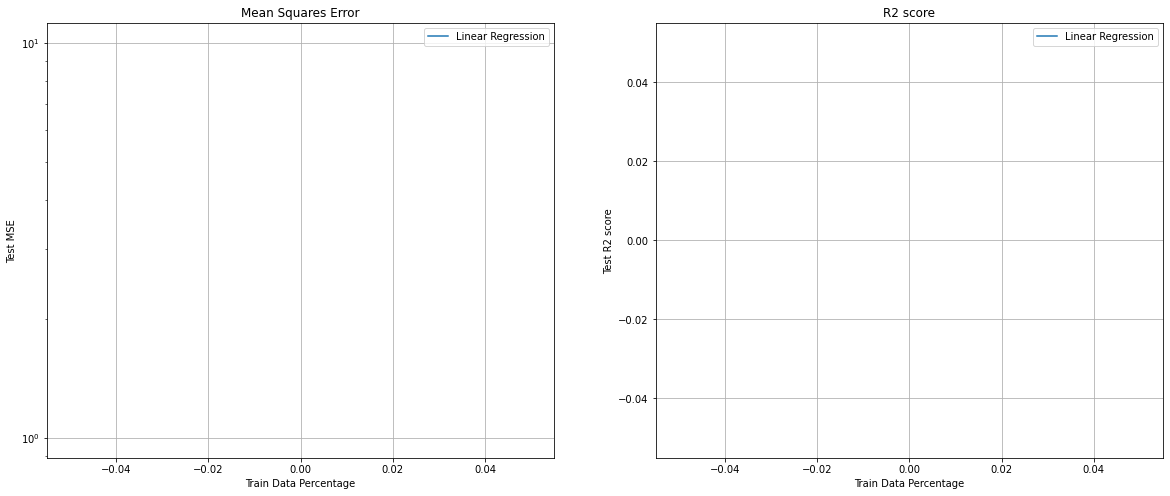

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

path = Path('./results/rbf')

#mses = np.array(mses)
#r2_scores = np.array(r2_scores)

mses = np.load(path/'rbf_mses_var_percentage.npy')
r2_scores = np.load(path/'rbf_scores_var_percentage.npy')

np.save(path/'rbf_mses_var_percentage', mses)
np.save(path/'rbf_scores_var_percentage', r2_scores)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)

# remove the fucky percentages
rows = np.abs(final_mses) < 10000
final_mses_chosen = final_mses[rows][2:]
mses_error_chosen = mses_error[rows][2:]
percentages_chosen = percentages[rows][2:]

plt.semilogy(percentages_chosen, final_mses_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(percentages_chosen, final_mses_chosen - mses_error_chosen, final_mses_chosen + mses_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')

final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)

# remove fucky values
r2_rows = np.abs(final_r2_score) < 10000
final_r2_score_chosen = final_r2_score[r2_rows][2:]
r2_score_error_chosen = r2_score_error[r2_rows][2:]
r2_percentages_chosen = percentages[r2_rows][2:]

plt.plot(r2_percentages_chosen, final_r2_score_chosen, label='Linear Regression')
plt.legend()
plt.fill_between(r2_percentages_chosen, final_r2_score_chosen - r2_score_error_chosen, final_r2_score_chosen + r2_score_error_chosen, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')


In [ ]:
noisy_mses = [[] for _ in range(N_ESSAIS)]
noisy_r2_scores = [[] for _ in range(N_ESSAIS)]
scale_factors = np.linspace(0.1, 3, 50)

for k in range(N_ESSAIS):
    for scale_factor in scale_factors:
        seed = random.randint(0, 10000)
        random_state = np.random.RandomState(seed)
        
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=True
        )

        # add noise to the first three columns which are our continuous features.
        X_train[:, 0] += np.random.normal(scale=scale_factor*np.std(X_train[:, 0]), size=X_train.shape[0])
        X_train[:, 1] += np.random.normal(scale=scale_factor*np.std(X_train[:, 1]), size=X_train.shape[0])
        X_train[:, 2] += np.random.normal(scale=scale_factor*np.std(X_train[:, 2]), size=X_train.shape[0])

        study = optuna.create_study(
            direction='maximize',
            study_name=f"RBF hyperparameters optimization for scale factor s={scale_factor} Essai={k}"
        )

        study.optimize(
            lambda trial: objective(
                trial, X_train, y_train, X_val, y_val, normalize=True, metric=r2_score),
            n_trials=10,
            # n_jobs=-1
        )
                
        rbf = RBF(
            study.best_params["n_clusters"], 
            study.best_params["sigma"],
            normalize=True
        ).fit(X_train, y_train)
        y_pred = rbf.predict(X_test)
        noisy_mses[k].append(mean_squared_error(y_test, y_pred))
        noisy_r2_scores[k].append(r2_score(y_test, y_pred))


[I 2022-06-22 03:10:43,590] A new study created in memory with name: RBF hyperparameters optimization for scale factor s=0.1 Essai=0
[I 2022-06-22 03:10:46,086] Trial 0 finished with value: 0.18856949906362197 and parameters: {'n_clusters': 135, 'sigma': 0.704540088484537}. Best is trial 0 with value: 0.18856949906362197.
[I 2022-06-22 03:10:48,590] Trial 1 finished with value: 0.8628454647267665 and parameters: {'n_clusters': 118, 'sigma': 3.0437318855280444}. Best is trial 1 with value: 0.8628454647267665.
[I 2022-06-22 03:10:50,691] Trial 2 finished with value: 0.694605301228836 and parameters: {'n_clusters': 86, 'sigma': 1.9316855922489156}. Best is trial 1 with value: 0.8628454647267665.
[I 2022-06-22 03:10:53,301] Trial 3 finished with value: 0.728076651191325 and parameters: {'n_clusters': 179, 'sigma': 1.77802810543794}. Best is trial 1 with value: 0.8628454647267665.
[I 2022-06-22 03:10:54,282] Trial 4 finished with value: 0.9478147408503352 and parameters: {'n_clusters': 53, 

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
[I 2022-06-22 03:11:16,579] Trial 5 finished with value: 0.9446995734943834 and parameters: {'n_clusters': 143, 'sigma': 4.702925833054136}. Best is trial 1 with value: 0.9580382081498632.
[I 2022-06-22 03:11:17,055] Trial 6 finished with value: 0.08492311967137928 and parameters: {'n_clusters': 21, 'sigma': 0.7609722113028929}. Best is trial 1 with value: 0.9580382081498632.
[I 2022-06-22 03:11:20,883] Trial 7 finished with value: 0.5195450241473405 and parameters: {'n_clusters': 235, 'sigma': 1.0481213514372938}. Best is trial 1 with value: 0.9580382081498632.
[I 2022-06-22 03:11:21,900] Trial 8 finished with value: 0.96948981441025 and parameters: {'n_clusters': 67, 'sigma': 9.12358619473601}. Best is trial 8 with value: 0.96948981441025.
[I 2022-06-22 03:11:22,315] Trial 9 finished w